In [13]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import pickle

In [3]:
# load the file
df = pd.read_csv('processed_steam_games.csv', index_col=0)
df

,title,genre,normalized_description
20200,Galactic Bowling,Sports,"['galactic', 'bowling', 'exaggerated', 'styliz..."
655370,Train Bandit,Action,"['law', 'look', 'showdown', 'atop', 'train', '..."
1732930,Jolt Project,Strategy,"['jolt', 'project', 'army', 'new', 'robotic', ..."
1355720,Henosis™,Adventure,"['henosis', 'mysterious', '2d', 'platform', 'p..."
1139950,Two Weeks in Painland,Adventure,"['game', 'play', 'hacker', 'arrange', 'deal', ..."
...,...,...,...
2669080,Mannerheim's Saloon Car,Simulation,"['marshal', 'mannerheim', 'saloon', 'car', 'tr..."
2736910,Beer Run,Casual,"['beer', 'run', 'indie', 'game', 'create', 'st..."
2743220,My Friend The Spider,Simulation,"['small', 'horror', 'narrative', 'game', 'isol..."
2293130,Path of Survivors,RPG,"['path', 'survivor', 'multi', 'class', 'auto',..."


In [4]:
# prepare the data
df['normalized_description'] = df['normalized_description'].apply(ast.literal_eval)
df['normalized_description'] = df['normalized_description'].apply(lambda x: ' '.join(x))

In [9]:
df.head(20)

,title,genre,normalized_description
20200,Galactic Bowling,Sports,galactic bowling exaggerated stylized bowling ...
655370,Train Bandit,Action,law look showdown atop train fight good luck t...
1732930,Jolt Project,Strategy,jolt project army new robotic project jolt con...
1355720,Henosis™,Adventure,henosis mysterious 2d platform puzzler player ...
1139950,Two Weeks in Painland,Adventure,game play hacker arrange deal gangster protago...
1469160,Wartune Reborn,RPG,feel tired auto fight feel tired boring numeri...
1659180,TD Worlds,Strategy,td world dynamic highly strategical game chall...
1968760,Legend of Rome - The Wrath of Mars,Casual,roman people honor simple warrior victory batt...
1178150,MazM: Jekyll and Hyde,RPG,mazm jekyll hyde darkly entertaining adventure...
320150,Deadlings: Rotten Edition,Adventure,death lonely friend facetome account hang orde...


In [5]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['normalized_description'])

In [6]:
# fit SVD
n_components = min(X.shape) - 1
svd = TruncatedSVD(n_components=n_components)
svd.fit(X)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# calculate the number of SVD components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

6624

In [8]:
# fit and transform TF-IDF vectors
svd = TruncatedSVD(n_components=6624)
X = svd.fit_transform(X)

In [10]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['genre'], test_size=0.2, random_state=42)

In [ ]:
# initiate a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=2, min_samples_split=2, random_state=42)

# train the model
clf.fit(X_train, y_train)

In [11]:
# predict
y_pred = clf.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.49      0.47      0.48      2530
   Adventure       0.36      0.83      0.50      3467
      Casual       0.70      0.26      0.38      1609
         RPG       0.59      0.50      0.54      2696
      Racing       0.86      0.38      0.53       576
  Simulation       0.61      0.07      0.13      1514
      Sports       0.94      0.14      0.24       539
    Strategy       0.67      0.38      0.49      2225

    accuracy                           0.47     15156
   macro avg       0.65      0.38      0.41     15156
weighted avg       0.57      0.47      0.44     15156



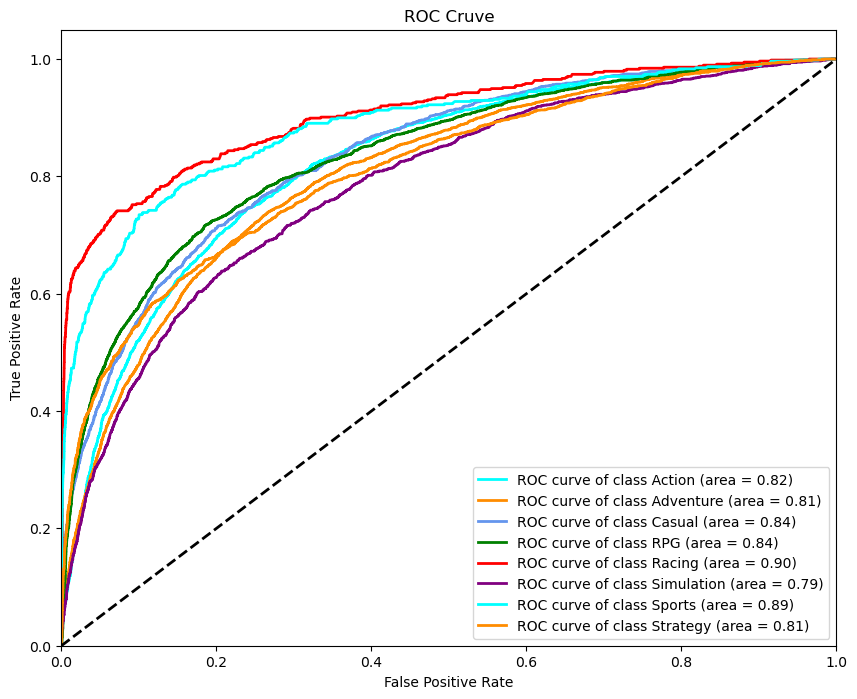

In [17]:
# binarize the output
y = label_binarize(y_test, classes=np.unique(y_test))
classes = ['Action', 'Adventure', 'Casual', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']
n_classes = y.shape[1]

# predict probabilities
y_prob = clf.predict_proba(X_test)

# compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Cruve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# save the model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(clf, file)